In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
plt.rc('font',family='AppleGothic')
import warnings
warnings.filterwarnings(action='ignore')

df_raw=pd.read_csv('../data/raw_data/train.csv')
df=df_raw.copy()

sample_submission_raw=pd.read_csv('../data/raw_data/sample_submission.csv')
sample_submission=sample_submission_raw.copy()

In [2]:
df['일시']=pd.to_datetime(df['일시'],format="%Y%m%d")
df.set_index('일시',inplace=True)

df['일'] = df.index.day
df['월'] = df.index.month
df['년'] = df.index.year

df['요일']=df.index.day_of_week
df['주말평일'] = df['요일'].apply(lambda x: '평일' if x < 5 else '주말')

# --

sample_submission['일시']=pd.to_datetime(sample_submission['일시'],format="%Y%m%d")
sample_submission.set_index('일시',inplace=True)

sample_submission['일'] = sample_submission.index.day
sample_submission['월'] = sample_submission.index.month
sample_submission['년'] = sample_submission.index.year

sample_submission['요일']=sample_submission.index.day_of_week
sample_submission['주말평일'] = sample_submission['요일'].apply(lambda x: '평일' if x < 5 else '주말')

In [3]:
from pytimekr import pytimekr
def get_holiday(_year):
    holidays=[]
    for holiday in pytimekr.holidays(year=_year):
        if pytimekr.red_days(holiday) != None:
            ans = [i.strftime("%Y-%m-%d") for i in pytimekr.red_days(holiday)]
            holidays.extend(ans)
        else:
            ans=holiday.strftime("%Y-%m-%d")
            holidays.append(ans)
    return list(set(holidays))

In [4]:
df.loc[get_holiday(2018),'주말평일'] = '주말'
df.loc[get_holiday(2019),'주말평일'] = '주말'
df.loc[get_holiday(2020),'주말평일'] = '주말'
df.loc[get_holiday(2021),'주말평일'] = '주말'
sample_submission.loc[sorted(get_holiday(2022))[:-1],'주말평일'] ='주말'

In [5]:
# 2
import numpy as np 

train_data_2 = df.copy()
test_data_2 = sample_submission.copy()

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

df_2018 = train_data_2[train_data_2.index.year == 2018]
df_2019 = train_data_2[train_data_2.index.year == 2019]
df_2020 = train_data_2[train_data_2.index.year == 2020]
df_2021 = train_data_2[train_data_2.index.year == 2021]

for col in df_2018.columns[:4]:
    df_2018[col][15:] = smooth(df_2018[col],4)[15:]
for col in df_2019.columns[:4]:
    df_2019[col][15:] = smooth(df_2019[col],4)[15:]
for col in df_2020.columns[:4]:
    df_2020[col][15:] = smooth(df_2020[col],4)[15:]
for col in df_2021.columns[:4]:
    df_2021[col][15:] = smooth(df_2021[col],4)[15:]

train_data_2=pd.concat([df_2018,df_2019,df_2020,df_2021])

In [6]:
train_data_2.drop(train_data_2[train_data_2['월']==12].index,inplace=True)

In [7]:
from sklearn.preprocessing import LabelEncoder
lbe = LabelEncoder()

train_data_2['주말평일'] = lbe.fit_transform(train_data_2['주말평일'])
test_data_2['주말평일'] = lbe.transform(test_data_2['주말평일'])

train_data_2=pd.concat([train_data_2.drop(['월','요일'],axis=1),
                      pd.get_dummies(train_data_2['월']),
                      pd.get_dummies(train_data_2['요일'])],axis=1)

test_data_2=pd.concat([test_data_2.drop(['월','요일'],axis=1),
                     pd.get_dummies(test_data_2['월']),
                     pd.get_dummies(test_data_2['요일'])],axis=1)

In [8]:
df_2018_raw = df[df.index.year == 2018]
df_2019_raw = df[df.index.year == 2019]
df_2020_raw = df[df.index.year == 2020]
df_2021_raw = df[df.index.year == 2021]

In [9]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

train_data_2_mms =mms.fit_transform(train_data_2.iloc[:,4:])
test_data_2_mms = mms.transform(test_data_2.iloc[:,4:])
train_target2 = train_data_2.iloc[:,:4]

In [11]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
# import lightgbm as lgb
# from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [13]:
# 2
import numpy as np 

def smooth(i):
    train_data_2 = df.copy()
    test_data_2 = sample_submission.copy()

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth

    df_2018 = train_data_2[train_data_2.index.year == 2018]
    df_2019 = train_data_2[train_data_2.index.year == 2019]
    df_2020 = train_data_2[train_data_2.index.year == 2020]
    df_2021 = train_data_2[train_data_2.index.year == 2021]

    for col in df_2018.columns[:4]:
        df_2018[col][15:] = smooth(df_2018[col],i)[15:]
    for col in df_2019.columns[:4]:
        df_2019[col][15:] = smooth(df_2019[col],i)[15:]
    for col in df_2020.columns[:4]:
        df_2020[col][15:] = smooth(df_2020[col],i)[15:]
    for col in df_2021.columns[:4]:
        df_2021[col][15:] = smooth(df_2021[col],i)[15:]
    return pd.concat([df_2018,df_2019,df_2020,df_2021])

In [15]:
df_2=smooth(2)
df_3=smooth(3)
df_4=smooth(4)
df_5=smooth(5)
df_7=smooth(7)
df_10=smooth(10)
df_15=smooth(15)

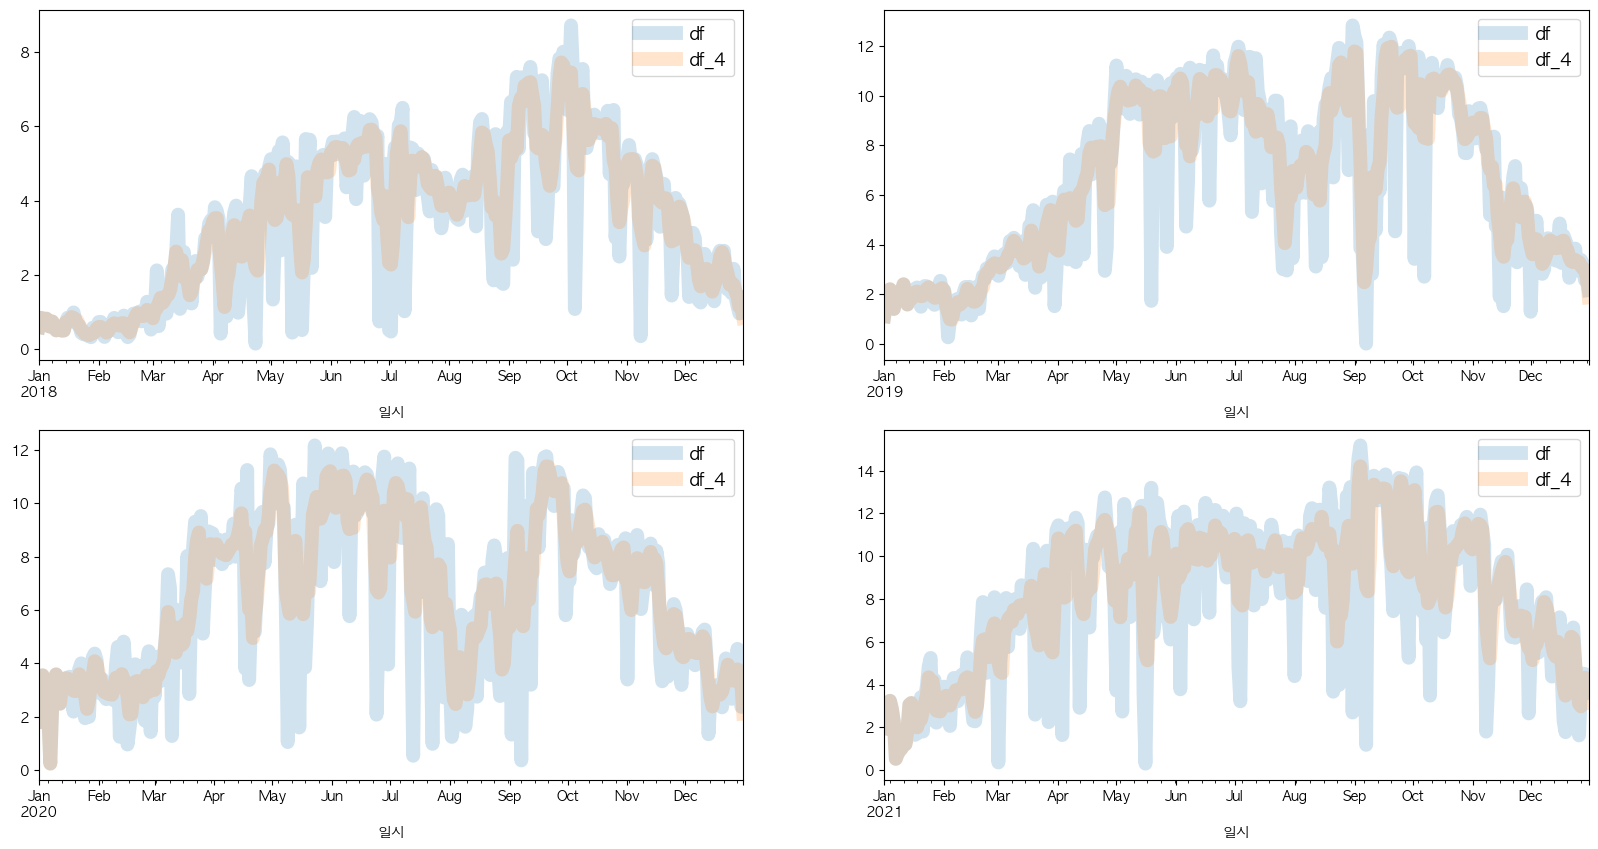

In [16]:
plt.subplot(2,2,1)
df[df['년']==2018].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df')
# df_2[df_2['년']==2018].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_2')
# df_3[df_3['년']==2018].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_3')
df_4[df_4['년']==2018].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_4')
# df_5[df_5['년']==2018].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_5')
# df_7[df_7['년']==2018].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_7')
plt.legend(fontsize=13)
plt.subplot(2,2,2)
df[df['년']==2019].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df')
# df_2[df_2['년']==2019].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_2')
# df_3[df_3['년']==2019].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_3')
df_4[df_4['년']==2019].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_4')
# df_5[df_5['년']==2019].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_5')
# df_7[df_7['년']==2019].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_7')
plt.legend(fontsize=13)
plt.subplot(2,2,3)
df[df['년']==2020].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df')
# df_2[df_2['년']==2020].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_2')
# df_3[df_3['년']==2020].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_3')
df_4[df_4['년']==2020].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_4')
# df_5[df_5['년']==2020].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_5')
# df_7[df_7['년']==2020].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_7')
plt.legend(fontsize=13)
plt.subplot(2,2,4)
df[df['년']==2021].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df')
# df_2[df_2['년']==2021].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_2')
# df_3[df_3['년']==2021].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_3')
df_4[df_4['년']==2021].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_4')
# df_5[df_5['년']==2021].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_5')
# df_7[df_7['년']==2021].iloc[:,0].plot(figsize=(20,10),alpha=0.2,lw=10,label='df_7')
plt.legend(fontsize=13)
plt.show()

In [76]:
diff_df=list()
for i in range(1,13):
    temp_1=df_2018_raw[df_2018_raw['월'].isin([i])].iloc[:,:4].mean()
    temp_2=df_2019_raw[df_2019_raw['월'].isin([i])].iloc[:,:4].mean()
    temp_3=df_2020_raw[df_2020_raw['월'].isin([i])].iloc[:,:4].mean()
    temp_4=df_2021_raw[df_2021_raw['월'].isin([i])].iloc[:,:4].mean()
    vars()[f'diff_{i}'] = pd.concat([temp_1,temp_2,temp_3,temp_4],axis=1)
    vars()[f'diff_{i}'].columns = [f'2018_{i}',f'2019_{i}',f'2020_{i}',f'2021_{i}']
    diff_df.append(vars()[f'diff_{i}'].diff(axis=1).fillna(1).mean(axis=1))
pd.concat(diff_df,axis=1)

In [77]:
pd.concat(diff_df,axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11
광진구,0.715161,1.192625,1.526323,1.917100,1.477371,1.559017,1.596355,1.662323,1.607650,1.372113,1.296233,1.084935
동대문구,0.678532,1.003554,1.352839,1.723383,1.502435,1.734133,1.749323,1.674048,1.724200,1.472710,1.368367,1.078597
성동구,0.650355,1.080536,1.313226,1.683467,1.241306,1.318783,1.315306,1.388226,1.417033,1.172323,1.104500,0.902935
중랑구,0.569532,0.812393,1.061790,1.342850,1.188435,1.274283,1.267306,1.260081,1.294800,1.175274,1.067033,0.818500


In [78]:
diff_1

,2018_1,2019_1,2020_1,2021_1
광진구,0.613419,1.949613,3.019613,2.474065
동대문구,0.441548,1.138323,1.872839,2.155677
성동구,0.708903,1.620516,2.412774,2.310323
중랑구,0.190968,0.793355,1.339032,1.469097


In [79]:
diff_11

,2018_11,2019_11,2020_11,2021_11
광진구,3.992000,6.303800,6.249200,8.176933
동대문구,2.421800,3.762800,5.076933,6.895267
성동구,3.254067,4.843533,5.386000,6.672067
중랑구,1.633533,2.706867,3.919200,4.901667


In [82]:
df[(df['년']==2021) &  (df['월']==11)]

,광진구,동대문구,성동구,중랑구,일,월,년,요일,주말평일
일시,,,,,,,,,
2021-11-01,10.632,9.248,9.080,6.354,1,11,2021,0,평일
2021-11-02,11.508,9.898,9.804,7.076,2,11,2021,1,평일
2021-11-03,11.330,9.942,9.726,6.890,3,11,2021,2,평일
2021-11-04,11.290,9.596,9.412,6.570,4,11,2021,3,평일
2021-11-05,11.950,9.910,9.834,6.696,5,11,2021,4,평일
2021-11-06,11.270,8.254,9.206,6.438,6,11,2021,5,주말
2021-11-07,10.560,7.628,9.008,5.934,7,11,2021,6,주말
2021-11-08,1.796,1.958,1.216,1.540,8,11,2021,0,평일
2021-11-09,3.904,3.654,2.766,2.756,9,11,2021,1,평일
